# Анализ неструктурированных данных. Задание. Распознавание цифр. Вариант 5

Выполнил студент 325 группы Жигалов Никита Сергеевич

## Постановка (README)

Я решил строить сеть для распознования 5 различных букв латинского алфавита: N, K, P, R, Z.

Для этого был создан датасет `letters_dataset`, в котором содержится по 10 вручную созданных примеров на каждую букву. Файлы имеют разрешение 32 на 32, и формат `.png`, создать свои примеры (*бесплатно*) можно на сайте [piskel](https://www.piskelapp.com/p/create/sprite), главное выставить соответствующие настройки.

Датасет `augmented_dataset` - содержит дополнительную аугментацию букв, содержащихся в `letters_dataset`, она заключается в сдвиге данных по картинке и рисовании букв различными цветами.

В папку `models` сохранялись рабочие модели для последующего их использования (чтобы не тратить время на обучение при повторных запусках ноутбука)

В папке `test_inputs` лежат 10 тестовых примеров различных букв (созданных отдельно, они не встречаются в тренировочном датасете), сюда же необходимо добавлять новые примеры при желании дополнительно протестировать модель.

В папке `augmented_input_K`, содержится 15 примеров аугментированных букв K, которая для сети является наиболее проблемной из-за ее схожести с буквой R, в конце ноутбука есть возможность проверить на нем работу нейросети и убедится, что ошибки классификации возникают.

Для корректной работы программы необходимо, наличие всех папок, не перемещайте этот ноутбук в другие директории!

При работе использовались библиотеки:

* pillow (PIL), а конкретно Image, для конвертации `.png` файлов в формат numpy-массивов, а также для вывода их на экран
* numpy - для работы с массивами пикселей, представляющих картинки
* pandas - для ковертации массивов данных в удобный формат DataFrame, и последующего его использования для разделения данных на тренировочную и обучающие выборки
* tensorflow, а конкретно keras, для построения трехслойной нейронной сети, осуществляющей обработку изображений
* os - для чтения файлов
* matplotlib.pyplot - для вывода рисунков символов на экран
* train_test_split из sklearn для удобного (случайного) разбиения данных на обучающую и тестовую выборки

## Подготовка данных для работы

Подключаем необходимые библиотеки

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-11-16 16:40:34.620943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731764434.632500  175239 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731764434.636623  175239 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 16:40:34.650436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Получаем расположение файла ноутбука

In [3]:
path = os.getcwd()

Создаем метки классов

In [4]:
labels = ['K', 'N', 'P', 'R', 'Z'] # метки для картинок
y_not_augm = np.repeat(np.arange(5), 10) # соответствующий числовой эквивалент метки (от 0 до 4)
y_augm = np.repeat(np.arange(5), 15) # метки аугментированных данных
y_not_augm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [5]:
col_names = ['pxl' + str(i) for i in range(1024)] # задаем названия колонок в датафрейме
# всего пикселей 32 * 32 = 1024

Заполняем DataFrame для дальнейшего разбиения на train и test

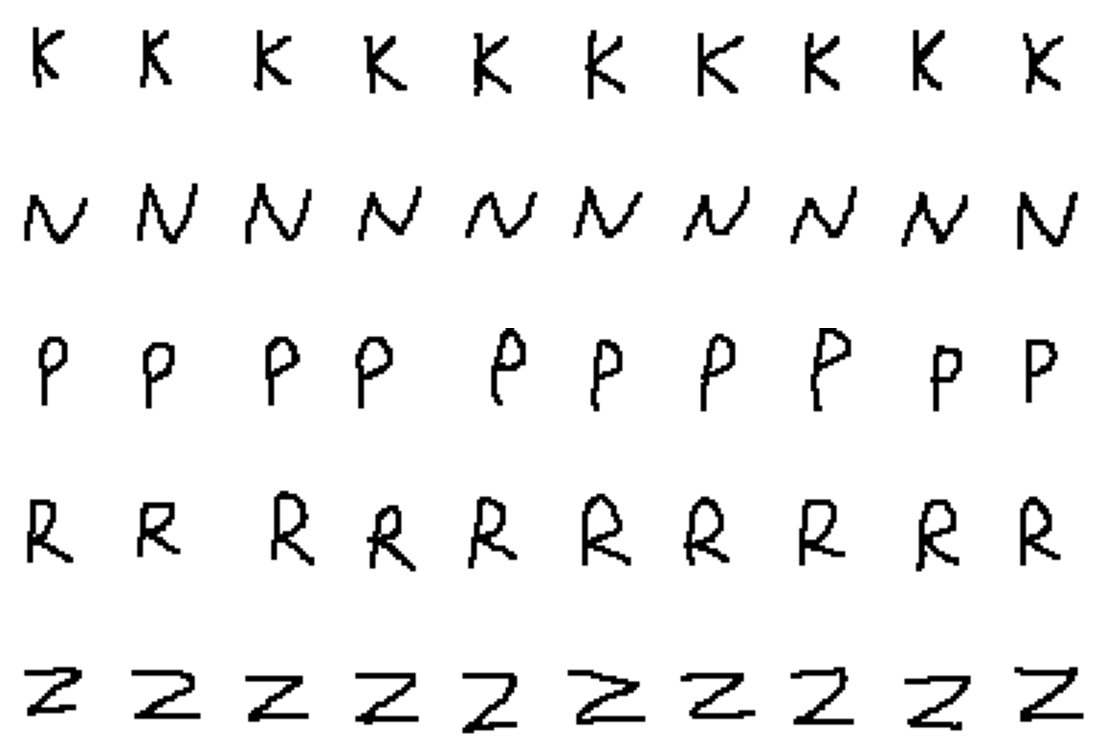

In [6]:
# сначала неаугментированные данные
df = pd.DataFrame(columns=col_names)
num_classes = 5 # число классов
samples_per_class = 10 # число объектов в классе
plt.figure(figsize=(14, 10))
for j, l in enumerate(labels):
    for i in range(1, 10 + 1):
        image = Image.open(path + '/letters_dataset/' + l + '_' + str(i) + '.png') # открываем изображения        
        new_image = image.convert('L')  # превращаем картинку в черно-белую (для уменьшения размерности)
        plt.subplot(num_classes, samples_per_class, j * 10 + i) # вывод всех рисунков на одном полотне
        plt.imshow(np.asarray(new_image), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        numpydata = np.asarray(new_image).flatten() # преобразуем пиксели в числовой формат
        df.loc[l + '_' + str(i)] = numpydata  # добавляем новую строку в датафрейм
                

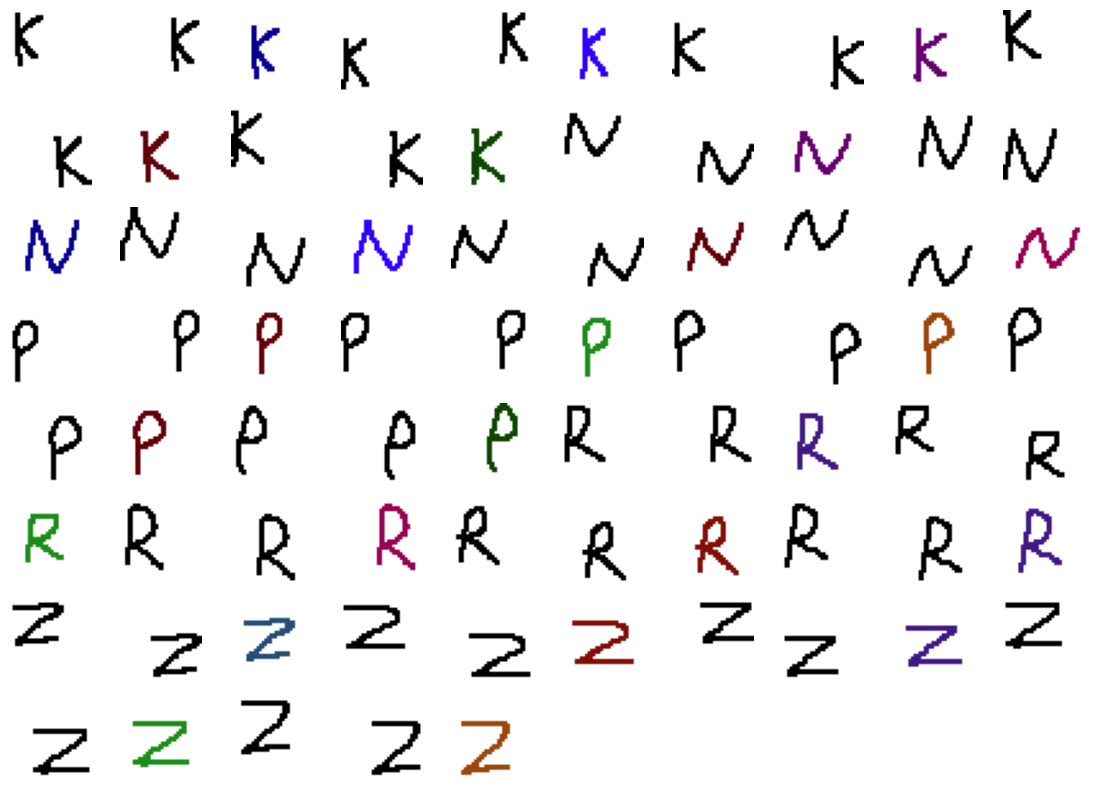

In [8]:
lines_num = 8 # число классов
row_size = 10 # число объектов в классе
plt.figure(figsize=(14, 10))
for j, l in enumerate(labels):
    for i in range(1, 5 + 1):
        for q in range(1, 3 + 1):
            image = Image.open(path + '/augmented_dataset/' + l + '_' + str(i) + '_' + str(q) + '.png') # открываем изображения        
            new_image = image.convert('L')  # превращаем картинку в черно-белую (для уменьшения размерности)
            plt.subplot(lines_num, row_size, j * 15 + (i-1) * 3 + q) # вывод всех рисунков на одном полотне
            plt.imshow(image)
            plt.axis('off')
            numpydata = np.asarray(new_image).flatten() # преобразуем пиксели в числовой формат
            df.loc[l + '_' + str(i) + '_' + str(q)] = numpydata  # добавляем новую строку в датафрейм

Также можем наблюдать все рисунки букв, входящих в наш тренировочный датасет

In [9]:
y = np.hstack((y_not_augm, y_augm))
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [10]:
df.insert(0, "letter", y, allow_duplicates=True)

Разбиваем данные на train и test

In [82]:
data = np.array(df)
X_train, X_test, y_train, y_test = train_test_split(data[:, 1:], data[:, 0], random_state=42, test_size=0.2, stratify=y)

In [83]:
data.shape

(125, 1025)

In [84]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100, 1024), (100,), (25, 1024), (25,))

Приводим значения пикселей к [0, 1], а метки y_train и y_test к категориальным переменным 

In [85]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

y_train_categorical = keras.utils.to_categorical(y_train, 5)
y_test_categorical = keras.utils.to_categorical(y_test, 5)

## Создание модели

Обучаем модель: слои:

1. вход ввиде тензора (32, 32, 1), применяем сверточную нейросеть с ядром свертки 5 на 5 -> на выходе будет сгенерировано 32 карты признаков (feature maps), активация - `ReLU`
2. применяем Max Pooling с размером окна 7 на 7 - нам важно отслеживать расстояние между пикселями, например в случае R, чтобы определить ее верхнюю половину, поэтому берем размер окна больше, шаг окна 2 на 2, т.е. 2 по горизонтали и 2 по вертикали
3. применяем сверточную нейросеть с ядром свертки 5 на 5, активация - `ReLU`
4. еще раз применяем Max Pooling c размером окна 7 на 7
5. линейный слой карты признаков -> 128 выход, активация - `ReLU`
6. линейный слой: 128 вход -> 5 выход, активация - `softmax` (приводим выходы к вероятностям выбрать ту или иную метку класса)

Оптимизация - `adam`, функцию потерь берем характерную для данной задачи - `categorical_crossentropy`, а метрику - `accuracy`
Вполне достаточно 40 эпох, потому что потом модель начинает переобучатся

In [126]:
my_nn = keras.models.Sequential([
                                layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 1)),
                                layers.MaxPooling2D((7, 7), strides=2),
                                layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
                                layers.MaxPooling2D((7, 7), strides=2),
                                layers.Flatten(),
                                layers.Dense(units=128, activation='relu'),
                                layers.Dense(units=5, activation='softmax')
                                ]) # задаем нашу нейросеть
my_nn.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy']) # задаем целвую функцию потерь и метрику, а также оптимизатор

my_nn.fit(X_train.reshape(100, 32, 32, 1), y_train_categorical, epochs=40, verbose=False) # обучаем модель
loss, accuracy = my_nn.evaluate(X_test.reshape(-1, 32, 32, 1), y_test_categorical) # получаем качество на тестовой выборке
print(loss, accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0548
0.05482092499732971 1.0


Внимание! Датасет маленький, если менять random_state, то модель может получится хуже

На лучшей модели (`m9.keras`) accuracy получился 1.0

In [133]:
# my_nn.save('models/m10.keras') # сохраняем лучшую модель

## Проверка работы модели на пользовательских тестах

В ячейке ниже загружается лучший пример модели, если хотите использовать модель полученную на предыдущих шагах, то пропустите выполнение этой ячейки

In [134]:
my_nn = keras.models.load_model(path + '/models/m9.keras')

In [135]:
loss, accuracy = my_nn.evaluate(X_test.reshape(-1, 32, 32, 1), y_test_categorical)
print(f'Loss: {loss}, accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 1.0000 - loss: 0.0548
Loss: 0.05482092499732971, accuracy: 1.0


Пример ниже - шаблонный, если хотите добавить свои данные то необходимо: 
1. Формат файла `.png`, размер в пикселях 32 на 32 
2. Это нужно делать в папку `test_inputs`, обозначая примеры последовательно, например, если добавлять новые тестовые символы к текущим десяти, то следующий файл должен иметь название `letter_11.png`, потом `letter_12.png`, и т.д.
3. Если нужен вывод на экран тестовых данных, то следует поменять переменные `num_of_samples` на новое число входных данных, а `split_to_rows` на число рядов в которых они будут выводится, `num_of_samples` должно быть кратно `split_to_rows`!!! Иначе возникнет ошибка.
4. В противном случае для быстрой проверки, можно поменять значение переменной `make_plot` на `False`, тогда изображения выводится не будут, но модель все равно отобразит свои предсказания
5. Создание новых примеров - [piskel](https://www.piskelapp.com/p/create/sprite)


Два подготовленных варианта входных данных:

просто 10 примеров по 2 каждой буквы
15 аугментированных вариаций буквы K Для использования первого варианта - загрузить следующую ячейку, для второго следующую после него

Первый вариант:

In [131]:
num_of_samples = 10 # число входных данных
split_to_rows = 2 # число строк при выводе картинок
in_path = '/test_inputs'

Второй вариант:

In [129]:
num_of_samples = 15 # число входных данных
split_to_rows = 3 # число строк при выводе картинок
in_path = '/augmented_input_K'

1 The letter is probably Z
2 The letter is probably Z
3 The letter is probably N
4 The letter is probably N
5 The letter is probably P
6 The letter is probably P
7 The letter is probably R
8 The letter is probably R
9 The letter is probably K
10 The letter is probably K


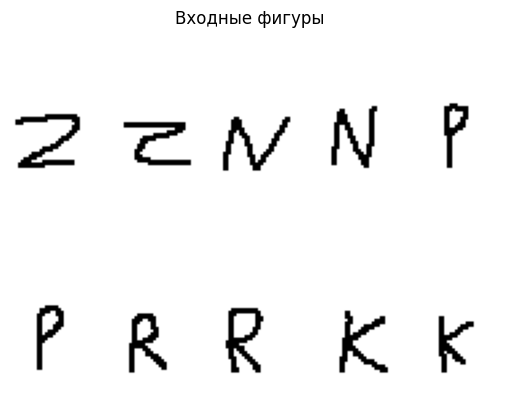

In [132]:
index = 1
# ______________
make_plot = True # изменить на False для быстрого добавления новых данных
# ______________
while os.path.isfile(path + in_path + f"/letter_{index}.png"):
    img = Image.open(path + in_path + f"/letter_{index}.png")
    # здесь конвертируем в ч/б формат и превращаем в формат массива, который можно передать на вход как тренировочные данные
    new_image = np.asarray(img.convert('L'))
    
    if make_plot: # вывод рисунка буквы на одном полотне
        plt.subplot(split_to_rows, num_of_samples // split_to_rows, index)
        plt.imshow(img)
        plt.axis('off')
        
    prediction = my_nn.predict(new_image.reshape(1, 32, 32, 1), verbose=False) # получаем предсказание
    result = labels[np.argmax(prediction)] # достаем соответствующую метку класса
    print(f"{index} The letter is probably {result}")
    index += 1 

if make_plot:
    plt.suptitle('Входные фигуры')
    plt.show()

Как можно видеть для подготовленного примера, модель ошиблась в двух местах, классифицировав R в примере 8, как K и наоборот, в примере 9 классифицировав K как R